In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime as dt
import os
import re
import pandas as pd
import random as rd
import numba
os.chdir('k:/a')

In [2]:
global gradientcolor
global dailycontactmin,dailycontactmax

dailycontactmin,dailycontactmax=60.,1000.

In [3]:
gradientcolor=['#cfcaca',
 '#cec9c9',
 '#cdc8c8',
 '#ccc7c7',
 '#cbc7c6',
 '#cac6c5',
 '#c9c5c4',
 '#c8c4c3',
 '#c7c3c3',
 '#c6c2c2',
 '#c5c1c1',
 '#c4c0c0',
 '#c3c0bf',
 '#c2bfbe',
 '#c1bebd',
 '#c0bdbc',
 '#c0bcbb',
 '#bfbbba',
 '#bebab9',
 '#bdb9b8',
 '#bcb9b7',
 '#bbb8b6',
 '#bab7b5',
 '#b9b6b4',
 '#b8b5b4',
 '#b7b4b3',
 '#b6b3b2',
 '#b5b2b1',
 '#b4b2b0',
 '#b3b1af',
 '#b2b0ae',
 '#b1afad',
 '#b0aeac',
 '#afadab',
 '#adaca9',
 '#acaaa8',
 '#aba9a7',
 '#aaa8a6',
 '#a9a7a5',
 '#a7a6a3',
 '#a6a5a2',
 '#a5a4a1',
 '#a4a3a0',
 '#a3a19f',
 '#a1a09d',
 '#a09f9c',
 '#9f9e9b',
 '#9e9d9a',
 '#9d9c99',
 '#9c9b98',
 '#9a9a96',
 '#999895',
 '#989794',
 '#979693',
 '#969592',
 '#949490',
 '#93938f',
 '#92928e',
 '#91918d',
 '#908f8c',
 '#8e8e8a',
 '#8d8d89',
 '#8c8c88',
 '#8a8a86',
 '#888884',
 '#858582',
 '#838380',
 '#81817d',
 '#7f7f7b',
 '#7c7c79',
 '#7a7a77',
 '#787875',
 '#767673',
 '#737471',
 '#71716f',
 '#6f6f6c',
 '#6d6d6a',
 '#6a6b68',
 '#686966',
 '#666664',
 '#646462',
 '#616260',
 '#5f605e',
 '#5d5d5b',
 '#5b5b59',
 '#585957',
 '#565755',
 '#545553',
 '#525251',
 '#4f504f',
 '#4d4e4d',
 '#4b4c4a',
 '#494948',
 '#464746',
 '#444544',
 '#434443',
 '#414241',
 '#404140',
 '#3f403f',
 '#3e3f3e',
 '#3c3d3c',
 '#3b3c3b',
 '#3a3b3a',
 '#393939',
 '#373837',
 '#363736',
 '#353635',
 '#343434',
 '#323332',
 '#313231',
 '#303030',
 '#2f2f2f',
 '#2d2e2d',
 '#2c2c2c',
 '#2b2b2b',
 '#2a2a2a',
 '#282928',
 '#272727',
 '#262626',
 '#252525',
 '#232323',
 '#222222',
 '#212121',
 '#202020',
 '#1e1e1e',
 '#1d1d1d',
 '#1c1c1c',
 '#1c1c1c',
]

In [4]:
#get demographic data
def get_demographic(un_total,un_birth,un_death,country,year):
    
    #the unit is in '000
    population=un_total['Value'][un_total['Country or Area']==country][un_total['Year(s)']==(year+1)][un_total['Variant']=='Medium'].iloc[0]*1000
    population0=un_total['Value'][un_total['Country or Area']==country][un_total['Year(s)']==(year)][un_total['Variant']=='Medium'].iloc[0]*1000
    
    #for some reason, un doesnt provide crude rate per year, only annual rate per 5 year
    yearrange='%s-%s'%(2000+(year-2000)//5*5,2005+(year-2000)//5*5)
    
    #crude birth and death rate per 1000 people
    birth=un_birth['Value'][un_birth['Country or Area']==country][un_birth['Year(s)']==yearrange][un_birth['Variant']=='Medium'].iloc[0]/1000
    death=un_death['Value'][un_death['Country or Area']==country][un_death['Year(s)']==yearrange][un_death['Variant']=='Medium'].iloc[0]/1000
    
    #avoid python float error
    birth=round(birth,6)
    death=round(death,6)
    population=round(population,0)
    population0=round(population0,0)
    
    return (birth,death,population,population0)

In [5]:
#cleansing data
def prepare_data(df,demographic,country):
    
    birth,death,population,population0=demographic
    
    data=df[df['Country/Territory/Area']==country]
    data.set_index('report date',inplace=True)
    data.index=pd.to_datetime(data.index)

    #Total deaths denotes D in the dynamic system
    data=data[['Total deaths','Confirmed cases']].copy(deep=True)
    
    #currently infected denotes I in the dynamic system
    data['currently infected']=(data['Confirmed cases']-data['Total deaths'])

    #time denotes t in the dynamic system
    dif=pd.Series(data.index).diff()
    data['time']=dif.fillna('0').apply(lambda x: re.findall('\d+',str(x))[0]).astype(int).cumsum().tolist()

   #the tricky part is the susceptible
    #it is the total population minus confirmed cases
    #and the total population should also include natural birth and death

    #first we need to convert annual rate to daily rate as we got daily data
    birthdaily=(birth+1)**(1/365)-1
    deathdaily=(death+1)**(1/365)-1

    #the daily population projection excludes immigration and emigration
    #first, its challenging to find daily immigration and emigration data
    #i am pretty sure the government has it but i cannot find it for free
    #second, when the quarantines kicked in, no flights were allowed
    #many places in asia became a closed system
    ppl=pd.DataFrame()
    ppl['population']=[round(population0*((1+birthdaily-deathdaily)**i),0) for i in range(365)]
    ppl['report date']=[pd.to_datetime('2020-01-01')+dt.timedelta(days=i) for i in range(365)]
    ppl.set_index('report date',inplace=True)
    
    #merge
    data=data.merge(ppl,left_index=True,right_index=True)

    #we have to preset the mean degree
    data['random graph probability']=0.0
    
    #susceptible denotes S in the dynamic system
    data['susceptible']=data['population']-data['Confirmed cases']
    
    data['theta']=genr_THETA(data['population'].tolist(),
                             data['susceptible'].tolist(),
                             rand_prob=data['random graph probability'].iloc[0])
    
    data['alpha']=birthdaily
    data['gamma']=deathdaily
    data['country']=country
    
    return data

In [6]:
#assume this is a barabási-albert graph
@numba.jit(nopython=True)
def prob_genr_func(z,N,rand_prob=0.02):
    
    kmin=dailycontactmin
    kmax=dailycontactmax
    
    degreelist=np.arange(kmin,kmax)
    thetalist=np.array([float(z)]*int(kmax-kmin))

    denominator=np.power(degreelist,3)    
    
    numerator_constant=2*kmin*(kmin+1)
    numerator_power=np.power(thetalist,np.arange(1,kmax-kmin+1))
    numerator=np.multiply(numerator_constant,numerator_power)
    
    
    return np.divide(numerator,denominator).sum()


@numba.jit(nopython=True)
def prob_genr_func_1st_dvt(z,N,rand_prob=0.02):
    
    kmin=dailycontactmin
    kmax=dailycontactmax
    
    degreelist=np.arange(kmin,kmax)
    denominator=np.power(degreelist,2)
    
    #efficiency
    if z==1:
        numerator=np.array([2*kmin*(kmin+1)]*int(kmax-kmin))
    else:        
        thetalist=np.array([float(z)]*int(kmax-kmin))        
        numerator_constant=2*kmin*(kmin+1)
        numerator_power=np.power(thetalist,np.arange(0,kmax-kmin))
        numerator=np.multiply(numerator_constant,numerator_power)  
    
    return np.divide(numerator,denominator).sum()


@numba.jit(nopython=True)
def prob_genr_func_2nd_dvt(z,N,rand_prob=0.02):  
    
    kmin=dailycontactmin
    kmax=dailycontactmax
    
    degreelist=np.arange(kmin,kmax)
    denominator=np.power(degreelist,2)
    
    #efficiency
    if z==1:
        numerator=np.array([2*kmin*(kmin+1)*(k-1) for k in degreelist])
    else:        
        thetalist=np.array([float(z)]*int(kmax-kmin))        
        numerator_constant=np.array([2*kmin*(kmin+1)*(k-1) for k in degreelist])
        numerator_power=np.power(thetalist,np.arange(-1,kmax-kmin-1))
        numerator=np.multiply(numerator_constant,numerator_power)  
    
    return np.divide(numerator,denominator).sum()

In [7]:
#generate S from probability generation function
@numba.jit(nopython=True)
def genr_S(N,THETA,rand_prob=0.02):
    
    S=[]
    
    for i in range(len(N)):
        S.append(N[i]*prob_genr_func(THETA[i],N[i],rand_prob=rand_prob))
    
    return S

In [8]:
#treat probability generating function as polynomial equation
#where probability is constant cuz we can compute them from power law
#theta becomes the unknown, the roots of polynomial equation
#this function prepares coefficients for polynomial equation
@numba.jit(nopython=True)
def poly_coeffs(N,S):
    
    kmax=dailycontactmax
    kmin=dailycontactmin
    
    degreelist=np.arange(kmin,kmax)
    denominator=np.power(degreelist,3)
    
    numerator=2*kmin*(kmin+1)
    
    param=np.divide(numerator,denominator)    
    coeff=np.array(list(param[::-1])+[-S/N])
    
    return coeff

@numba.jit(nopython=True)
def get_solution(root):    
    return [i.real for i in root if i.imag==0 and i.real>0]

#numba doesnt support domain change from real to complex
#our polynomial equation has a lot of complex roots
#due to its order of power
#unfortunately we will have to live with the slow performance
def genr_THETA(N,S,rand_prob=0.02):
    
    THETA=[]
    for ind in range(len(N)):
        coeff=poly_coeffs(N[ind],S[ind])
        root=np.roots(coeff)
        solution=get_solution(root)
        THETA+=solution
        
    return THETA

In [9]:
#modified version of sir model with vital dynamics
#include natural birth, natural death and virus death
@numba.jit(nopython=True)
def EB_SIRmodel(z,t,known,unknown):
    
    N,I,rand_prob=known
    beta,delta=unknown
    
    THETA=z[0]
    D=z[1]
    
    #edge based model requires fewer equations than degree based or pairwise
    dTHETAdt=-beta+beta*prob_genr_func_1st_dvt(THETA,N,rand_prob=rand_prob)/prob_genr_func_1st_dvt(1,N,rand_prob=rand_prob)+delta*(1-THETA)
    dDdt=delta*I
    
    dzdt=[dTHETAdt,dDdt]
    
    return dzdt

In [10]:
#put all differential equations together
def dynamicsystem(unknown):
    
    t=data['time'].tolist()
        
    #create a list to store fitted values
    fitted=np.zeros((len(t),2))
    
    #initial value
    fitted[0,0]=data['theta'].iloc[0]
    fitted[0,1]=data['Total deaths'].iloc[0]
    
    z0=fitted[0]
    
    #we compute the fitted value via iterations
    #becuz this way is compatible with non-linear least square
    for i in range(1,len(t)):
        
        #no report on sunday
        #i suppose WHO staff go to church as well
        #no, i am kidding, they deserve a break as well
        #as the time interval is not consistent
        #we need to pass the variable as a list
        interval=[t[i-1],t[i]]
        
        known=(data['population'].iloc[i],
               data['currently infected'].iloc[i],
               data['random graph probability'].iloc[i])
        
        z=odeint(EB_SIRmodel,z0,interval,args=(known,unknown))
        
        #each iteration, the last fitted value becomes the initial value
        z0=z[-1]
        
        #we update fitted via each iteration
        fitted[i]=z[-1]
                
    return fitted

In [11]:
#the cost of least square is the sum of squared error
def costfunction(unknown):
    
    fitted=dynamicsystem(unknown)
    
    cost=0.0
    
    #THETA,D
    actual=['theta','Total deaths']
    
    #we have 2 ordinary differential equations
    #so we include 2 errors in each round
    #and we standardize the errors by the actual values
    for i in range(len(data)):
        for j in range(len(actual)):
            
            #sometimes the actual data may be zero
            #we cannot standardize the error by division
            if data[actual[j]].iloc[i]==0:
                if round(fitted[i,j],0)>1:
                    cost+=1
                else:
                    cost+=0
            else:
                cost+=((fitted[i,j]-data[actual[j]].iloc[i])/data[actual[j]].iloc[i])**2 
    
    return cost

In [12]:
#using non linear least square to estimate the parameters of dynamic system
#as we can only find the local minimum
#the initial value is crucial to the result
def estimate(diagnosis=False,beta_guess=0.00002,
             delta_guess=0.04,**kwargs):
       
    #sum of squared error from initial guess
    sse=costfunction((beta_guess,delta_guess))
    
    if diagnosis:
        print(f'Initial SSE: {round(sse,2)}')
    
    #according to rule of thumb, we use nelder-mead
    #actually i exhausted all possibilities
    #this one was the best empirical result
    #the shortcoming is nelder-mead doesnt take constraints
    #all rates should be bounded by 0 and 1
    lse=minimize(costfunction,x0=(beta_guess,delta_guess),
                 method='Nelder-Mead')
        
    if lse.success:   
        
        #sum of squared error from successful result
        beta,delta=lse.x
        sse=costfunction((beta,delta))
        if diagnosis:
            print(f'Result SSE: {round(sse,2)}')
        return beta,delta
        
    else:
        #if it doesnt converge to local minimum
        #we print the result and find out why
        if diagnosis:
            print(lse)
        return 0,0,0

In [13]:
#generate final outcome for in sample data
def create_in_sample_output(diagnosis=False,**kwargs):
    
    #estimate parameters
    beta,delta=estimate(**kwargs)
    
    if beta<=0 or delta<=0 or beta>1 or delta>1:
        if diagnosis:
            print('\nFailed\n')
        return None
    
    if diagnosis:
        print(f'\nInfection Rate: {round(beta,10)}')
        print(f'Fatality Rate: {round(delta,5)}')
    

    #show reproductive ratio
    N0=int(data['population'].iloc[0])
    rand_prob=data['random graph probability'].iloc[0]
    R0=(beta/(beta+delta))*(prob_genr_func_2nd_dvt(1,N0,rand_prob=rand_prob)/prob_genr_func_1st_dvt(1,N0,rand_prob=rand_prob))
    
    data['R0']=R0
    if diagnosis:
        print(f'\nBasic Reproductive Ratio: {R0}\n')
    
    #get model predictions
    fitted=dynamicsystem((beta,delta))
    data['beta']=beta
    data['delta']=delta
    data['theta fitted']=fitted[:,0]
    data['death fitted']=fitted[:,1]
    data['susceptible fitted']=genr_S(data['population'].tolist(),
                                      data['theta fitted'].tolist(),
                                      rand_prob=rand_prob)
    data['infected fitted']=data['population']-data['susceptible fitted']-data['death fitted']

    #convert float to int
    for i in data.columns:
        if 'fitted' in i and 'theta' not in i:
            data[i]=data[i].apply(lambda x: round(x,0)).astype(int)
    
    sse=costfunction((beta,delta))
    
    return sse

In [14]:
#using random initial value to find the best starting point
#the best start point is defined by the minimum SSE of SI
#even SI are not in our differential equations
#we believe the global minimum should successfully capture SI as well
#in reality, its not a good idea to run 10k times
#it took the whole night to get a result
#luckily i chose to sleep it off
def find_init(num=10000):
    D={}

    for _ in range(num):

        beta_random=rd.randint(1,1e+10)/10**(rd.randint(11,21))
        delta_random=rd.randint(1,1e+10)/10**(rd.randint(11,21))

        try:
            temp=create_in_sample_output(beta_guess=beta_random,
                                         delta_guess=delta_random)
            if temp:
                D[(beta_random,delta_random)]=temp
        except:
            pass
        
    return dict(sorted(D.items(),key=lambda x:x[1]))

In [15]:
#the best initial guess should suffice to 3 criteria
#smallest SI sse,smallest overall sse and smallest r0
#and the default weight is slightly leaned towards SI sse
def find_best_init(D,weight=[0.4,0.3]):
    
    global data

    D2={}
    D3={}
    
    databackup=data.copy(deep=True)
    
    #calculate sum of squared error for S and I which is not in the system
    for i in D:
        data=databackup.copy(deep=True)
        beta_guess,delta_guess=i
        if create_in_sample_output(beta_guess=beta_guess, delta_guess=delta_guess):
            sse=[((data['currently infected']-data['infected fitted'])/data['currently infected'])**2,
            ((data['susceptible']-data['susceptible fitted'])/data['susceptible'])**2]

            totalsse=sum([sum(i) for i in sse])

            D2[(beta_guess,delta_guess)]=totalsse
            D3[(beta_guess,delta_guess)]=(data['R0'].iloc[0].item()-1)**2

    D2=dict(sorted(D2.items(),key=lambda x:x[1]))
    D3=dict(sorted(D3.items(),key=lambda x:x[1]))
    
    #the best initial guess should balance the overall sse, R0 and SI sse
    D4={}

    for i in D2:
        ind1=list(D.keys()).index(i)
        ind2=list(D2.keys()).index(i)        
        ind3=list(D3.keys()).index(i)

        D4[i]=ind1*weight[0]+ind2*weight[1]+ind3*(1-sum(weight))

    D4=dict(sorted(D4.items(),key=lambda x:x[1]))
    
    return D4

In [16]:
#create forecast
def create_forecast(demographic,diagnosis=False,length=365,**kwargs):
    
    global data
            
    if create_in_sample_output(diagnosis=diagnosis,**kwargs):
        
        #expand the time horizon of data
        start=data.index[-1]
        forecast=pd.DataFrame(index=[start+dt.timedelta(days=i) for i in range(1,length)],
                             columns=data.columns)        
        del forecast['population']
        
        #the same process as prepare_data
        birth,death,population,population0=demographic    
        birthdaily=(birth+1)**(1/365)-1
        deathdaily=(death+1)**(1/365)-1
        datelength=(forecast.index[-1]-pd.to_datetime('2020-01-01')).days        
        ppl=pd.DataFrame()
        ppl['population']=[round(population0*((1+birthdaily-deathdaily)**i),0) for i in range(datelength)]
        ppl['report date']=[pd.to_datetime('2020-01-01')+dt.timedelta(days=i) for i in range(datelength)]
        ppl.set_index('report date',inplace=True)
        
        #create forecast dataframe
        forecast=forecast.merge(ppl,left_index=True,right_index=True)
        
        #need the last row of data as initial values
        forecast=data.iloc[-1:].append(forecast,sort=False)        
        forecast.reset_index(inplace=True)        
        beta=data['beta'].iloc[0]
        delta=data['delta'].iloc[0]
        rand_prob=data['random graph probability'].iloc[0]        
        
        #forecast based upon differential equations
        for i in range(1,len(forecast)):
            
            THETA=forecast['theta fitted'].iloc[i-1]
            D=forecast['death fitted'].iloc[i-1]
            N=forecast['population'].iloc[i-1]
            I=forecast['infected fitted'].iloc[i-1]

            dTHETAdt=-beta+beta*prob_genr_func_1st_dvt(THETA,N,rand_prob=rand_prob)/prob_genr_func_1st_dvt(1,N,rand_prob=rand_prob)+delta*(1-THETA)
            dDdt=delta*I
            
            forecast.at[i,'theta fitted']=THETA+dTHETAdt
            forecast.at[i,'death fitted']=D+dDdt
            forecast.at[i,'susceptible fitted']=forecast['population'].iloc[i]*prob_genr_func(
                forecast['theta fitted'].iloc[i],forecast['population'].iloc[i],rand_prob=rand_prob)
            forecast.at[i,'infected fitted']=forecast['population'].iloc[i]-forecast['susceptible fitted'].iloc[i]-forecast['death fitted'].iloc[i]
        
        #remove initial values and append to data
        forecast.drop(0,inplace=True)
        forecast.set_index('index',inplace=True)
        data=data.append(forecast)
        data['country'].fillna(method='ffill',inplace=True)
        
        return True
    else:
        return None

In [17]:
#single plot for in sample data
def plot(actualcol,fittedcol,title,fig,order,color1,color2):    
    
    ax=fig.add_subplot(order)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.title(data['country'].iloc[0]+'\n'+title)
    plt.ylabel('number')
    plt.xlabel('date')
    
    data[actualcol].loc[data.dropna().index].plot(label='Actual',alpha=0.9,c=color1)
    data[fittedcol].loc[data.dropna().index].plot(label='Fitted',alpha=0.9,c=color2)
    
    plt.legend(loc=0)

In [18]:
#plot S,I,D in a 2 by 2 figure for in sample data
def plot_all(savefig=False,postfix='poisson'):
    
    #plot actual versus fitted
    iteration=[('susceptible','susceptible fitted','Susceptible Population',221,'#1f6521','#d6ce15'),
    ('currently infected','infected fitted','Currently Infected',222,'#f13c20','#f79e02'),
    ('Total deaths','death fitted','Virus-caused Death',223,'#4d6d9a','#99ced3')]

    fig=plt.figure(figsize=(12,8))

    for i in iteration:

        actualcol,fittedcol,title,order,color1,color2=i
        plot(actualcol,fittedcol,title,fig,order,color1,color2)
        
    #plot the forecast of S,I,D
    ax=fig.add_subplot(224)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.title(data['country'].iloc[0]+'\n'+'Forecast')
    plt.ylabel('number')
    plt.xlabel('date')
    
    
    for col,color in zip(['susceptible fitted',
                          'infected fitted',
                          'death fitted'],['#1f6521','#f13c20','#4d6d9a']):
        data[col].plot(label=col.replace(' fitted',''),alpha=0.7,c=color)
    
    plt.legend(loc=0)    
    
    #avoid messed up title and xlabel 
    plt.tight_layout(pad=1.5)
        
    if savefig:
        figname=f"graph-corona-{data['country'].iloc[0]}-{postfix}.png"
        plt.savefig(figname.lower())
    
    plt.show()

&nbsp;
### Pre-processing Data
&nbsp;

In [19]:
un_birth=pd.read_csv('birth.csv')
un_death=pd.read_csv('death.csv')
un_total=pd.read_csv('total.csv')
df=pd.read_csv('grand-corona.csv')

In [20]:
#using un geoscheme
europe=['Belarus',
 'Bulgaria',
 'Czechia',
 'Hungary',
 'Republic of Moldova',
 'Poland',
 'Romania',
 'Russian Federation',
 'Slovakia',
 'Ukraine',
 'Åland Islands',
 'Denmark',
 'Estonia',
 'Faroe Islands',
 'Finland',
 'Guernsey',
 'Iceland',
 'Ireland',
 'Isle of Man',
 'Jersey',
 'Latvia',
 'Lithuania',
 'Norway',
 'Sark',
 'Svalbard and Jan Mayen',
 'Sweden',
 'United Kingdom',
 'Albania',
 'Andorra',
 'Bosnia and Herzegovina',
 'Croatia',
 'Gibraltar',
 'Greece',
 'Italy',
 'Malta',
 'Montenegro',
 'North Macedonia',
 'Portugal',
 'San Marino',
 'Serbia',
 'Slovenia',
 'Spain',
 'Holy See',
 'Austria',
 'Belgium',
 'France',
 'Germany',
 'Liechtenstein',
 'Luxembourg',
 'Monaco',
 'Netherlands',
 'Switzerland',
 'Kosovo']

asia=['Kazakhstan',
 'Kyrgyzstan',
 'Tajikistan',
 'Turkmenistan',
 'Uzbekistan',
 'China',
 'Hong Kong',
 'Macau',
 'Japan',
 'Mongolia',
 "Democratic People's Republic of Korea",
 'Republic of Korea',
 'Taiwan',
 'Brunei Darussalam',
 'Cambodia',
 'Indonesia',
 "Lao People's Democratic Republic",
 'Malaysia',
 'Myanmar',
 'Philippines',
 'Singapore',
 'Thailand',
 'Timor-Leste',
 'Viet Nam',
 'Afghanistan',
 'Bangladesh',
 'Bhutan',
 'India',
 'Iran',
 'Maldives',
 'Nepal',
 'Pakistan',
 'Sri Lanka',
 'Armenia',
 'Azerbaijan',
 'Bahrain',
 'Cyprus',
 'Georgia',
 'Iraq',
 'Israel',
 'Jordan',
 'Kuwait',
 'Lebanon',
 'Oman',
 'Qatar',
 'Saudi Arabia',
 'Occupied Palestinian Territory',
 'Syrian Arab Republic',
 'Turkey',
 'United Arab Emirates',
 'Yemen']

africa=['Burundi',
 'Comoros',
 'Djibouti',
 'Eritrea',
 'Ethiopia',
 'Kenya',
 'Madagascar',
 'Malawi',
 'Mauritius',
 'Mayotte',
 'Mozambique',
 'Réunion',
 'Rwanda',
 'Seychelles',
 'Somalia',
 'South Sudan',
 'United Republic of Tanzania',
 'Uganda',
 'Zambia',
 'Zimbabwe',
 'Angola',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Democratic Republic of the Congo',
 'Congo',
 'Equatorial Guinea',
 'Gabon',
 'São Tomé and Príncipe',
 'Algeria',
 'Egypt',
 'Libya',
 'Morocco',
 'Sudan',
 'Tunisia',
 'Western Sahara',
 'Botswana',
 'Eswatini',
 'Lesotho',
 'Namibia',
 'South Africa',
 'Benin',
 'Burkina Faso',
 'Cabo Verde',
 "Côte d'Ivoire",
 'Gambia',
 'Ghana',
 'Guinea',
 'Guinea-Bissau',
 'Liberia',
 'Mali',
 'Mauritania',
 'Niger',
 'Nigeria',
 'Saint Helena, Ascension and Tristan da Cunha',
 'Senegal',
 'Sierra Leone',
 'Togo']

oceania=['Australia',
 'Christmas Island',
 'Cocos (Keeling) Islands',
 'Heard Island and McDonald Islands',
 'New Zealand',
 'Norfolk Island',
 'Fiji',
 'New Caledonia',
 'Papua New Guinea',
 'Solomon Islands',
 'Republic of Vanuatu',
 'Guam',
 'Republic of Kiribati',
 'Republic of the Marshall Islands',
 'Federated States of Micronesia',
 'Republic of Nauru',
 'Northern Mariana Islands',
 'Republic of Palau',
 'American Samoa',
 'Cook Islands',
 'French Polynesia',
 'Niue',
 'Pitcairn Islands',
 'Independent State of Samoa',
 'Tokelau',
 'Kingdom of Tonga',
 'Tuvalu',
 'Wallis and Futuna Islands']

lac=['Anguilla',
 'Antigua and Barbuda',
 'Aruba',
 'Bahamas',
 'Barbados',
 'Bonaire, Sint Eustatius and Saba',
 'British Virgin Islands',
 'Cayman Islands',
 'Cuba',
 'Curaçao',
 'Dominica',
 'Dominican Republic',
 'Grenada',
 'Guadeloupe',
 'Haiti',
 'Jamaica',
 'Martinique',
 'Montserrat',
 'Puerto Rico',
 'Saint Barthélemy',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Martin',
 'Saint Vincent and the Grenadines',
 'Sint Maarten',
 'Trinidad and Tobago',
 'Turks and Caicos Islands',
 'United States Virgin Islands',
 'Belize',
 'Costa Rica',
 'El Salvador',
 'Guatemala',
 'Honduras',
 'Mexico',
 'Nicaragua',
 'Panama',
 'Argentina',
 'Bolivia',
 'Brazil',
 'Chile',
 'Colombia',
 'Ecuador',
 'Falkland Islands',
 'French Guiana',
 'Guyana',
 'Paraguay',
 'Peru',
 'South Georgia and the South Sandwich Islands',
 'Suriname',
 'Uruguay',
 'Venezuela']

northam=['Bermuda',
 'Canada',
 'Greenland',
 'Saint Pierre and Miquelon',
 'United States of America']

#mapping region
region=[]

for i in range(len(df)):
    if df['Country/Territory/Area'][i] in europe:
        region.append('Europe')
    elif df['Country/Territory/Area'][i] in asia:
        region.append('Asia')
    elif df['Country/Territory/Area'][i] in oceania:
        region.append('Oceania')
    elif df['Country/Territory/Area'][i] in africa:
        region.append('Africa')
    elif df['Country/Territory/Area'][i] in lac:
        region.append('LAC')
    elif df['Country/Territory/Area'][i] in northam:
        region.append('North America')
    else:
        region.append('')
        
df['region']=region

#use groupby to create regional aggregation
regional=df.groupby(['region','report date']).sum()
regional.reset_index(inplace=True)
regional=regional[regional['region']!='']
regional=regional[['region','Confirmed cases','Total deaths','report date']]
regional.columns=['Country/Territory/Area','Confirmed cases','Total deaths','report date']

#create output
df=df.append(regional)
del df['region']
df.reset_index(inplace=True,drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [21]:
#reading from csv instead

# var=locals()
# mapping={'Algeria': 'al',
#          'Australia': 'au',
#          'Brazil': 'br',
#          'Canada': 'ca',
#          'Chile': 'cl',
#          'China': 'cn',
#          'Europe': 'eu',
#          'France': 'fr',
#          'Iran (Islamic Republic of)': 'ir',
#          'Italy': 'it',
#          'New Zealand': 'nz',
#          'Republic of Korea': 'kr',
#          'South Africa': 'sf',
#          'Spain': 'es',
#          'United States of America': 'us',
#          'World': 'tt',
#          'Turkey':'tk',
#          'Israel':'is',
#          'Africa':'af',
#          'Latin America and the Caribbean':'lc'}


# for i in mapping:
    
#     var[mapping[i]+'demographic']=get_demographic(un_total,un_birth,un_death,i,2019)
    
#     #the irritating part where different country names are used
#     #fucking politics
#     if i=='World':
#         country='Total'
#     elif i=='Latin America and the Caribbean':
#         country='LAC'
#     elif i=='Iran (Islamic Republic of)':
#         country='Iran'
#     else:
#         country=i
        
#     var['data'+mapping[i]]=prepare_data(df,
#                                         var[mapping[i]+'demographic'],country)

In [22]:
mapping={'Algeria': 'al',
         'Australia': 'au',
         'Brazil': 'br',
         'Canada': 'ca',
         'Chile': 'cl',
         'China': 'cn',
         'Europe': 'eu',
         'France': 'fr',
         'Iran (Islamic Republic of)': 'ir',
         'Italy': 'it',
         'New Zealand': 'nz',
         'Republic of Korea': 'kr',
         'South Africa': 'sf',
         'Spain': 'es',
         'United States of America': 'us',
         'World': 'tt',
         'Turkey':'tk',
         'Israel':'is',
         'Africa':'af',
         'Latin America and the Caribbean':'lc'}

var=locals()
for i in mapping:
    var[mapping[i]+'demographic']=get_demographic(un_total,un_birth,un_death,i,2019)    
    var['data'+mapping[i]]=pd.read_csv(f'corona-{mapping[i]}-powerlaw.csv')
    try:
        var['data'+mapping[i]].set_index('report date',inplace=True)
        
    except:
        var['data'+mapping[i]].set_index('Unnamed: 0',inplace=True)
    
    var['data'+mapping[i]].index=pd.to_datetime(var['data'+mapping[i]].index)


&nbsp;
### In-sample Data
&nbsp;

In [23]:
#using global variable is the worst idea
#but we need to call our dataframe inside the differential equations
#odeint prefers a clean dynamic system function with only numerical inputs
#therefore we have to define the dataframe as the global variable
global data

In [24]:
# to find initial guess if needed
# data=datatt.copy(deep=True)
# D=find_init(num=200)
# D4=find_best_init(D)


Infection Rate: 3.38587e-05
Fatality Rate: 0.00328

Basic Reproductive Ratio: 1.8122981856370617



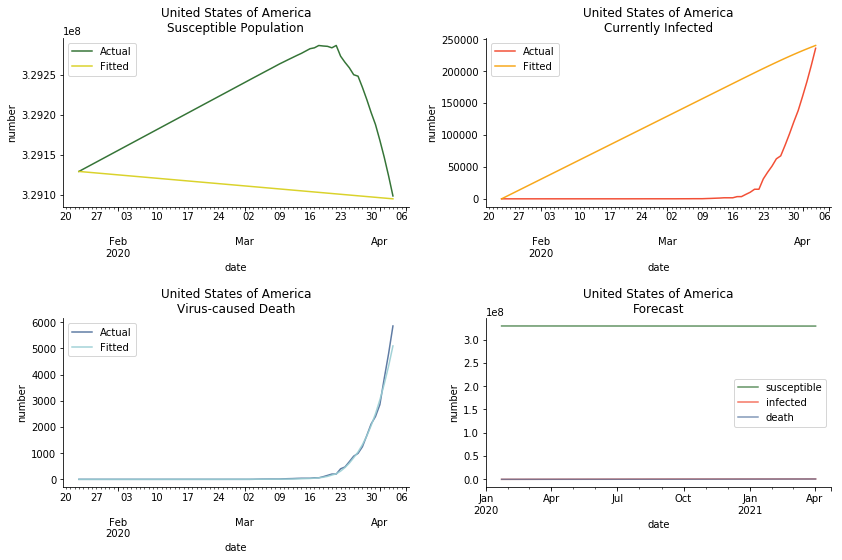

In [25]:
data=dataus.copy(deep=True)
beta_guess,delta_guess=0.0000366,0.003
if create_forecast(usdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-us--powerlaw.csv')


Infection Rate: 0.0001074555
Fatality Rate: 0.01028

Basic Reproductive Ratio: 1.8362434062511688



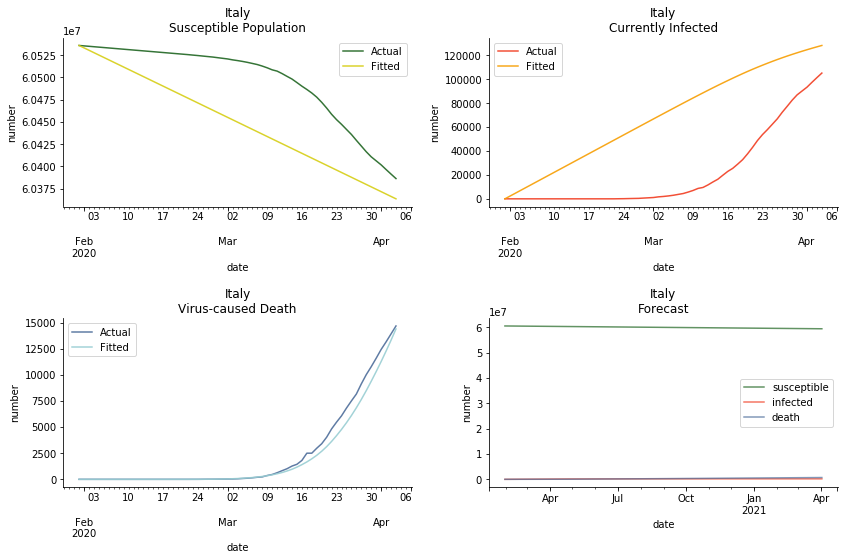

In [26]:
data=datait.copy(deep=True)
beta_guess,delta_guess=0.0192085, 0.009011
if create_forecast(itdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-it--powerlaw.csv')


Infection Rate: 5.22766e-05
Fatality Rate: 0.00421

Basic Reproductive Ratio: 2.174436441850937



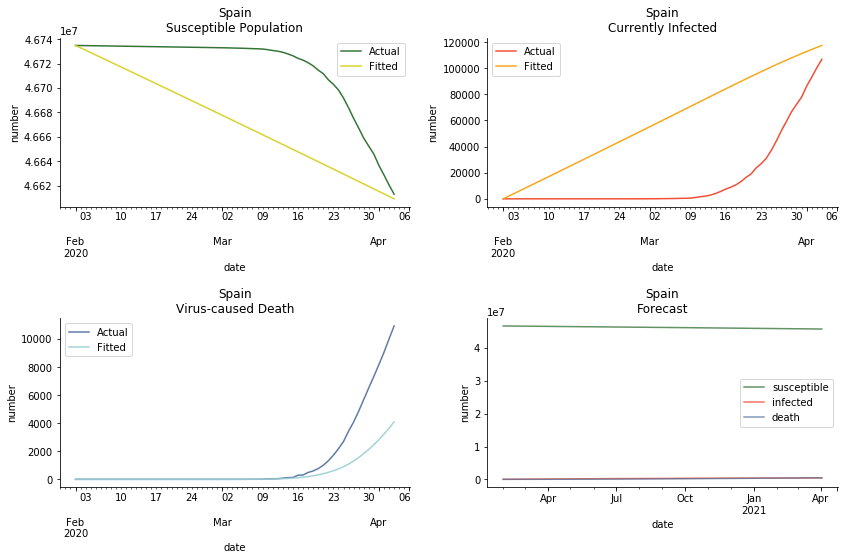

In [27]:
data=dataes.copy(deep=True)
beta_guess,delta_guess=0.000051,0.005
if create_forecast(esdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-es--powerlaw.csv')


Infection Rate: 4.95082e-05
Fatality Rate: 0.00485

Basic Reproductive Ratio: 1.7941626381763813



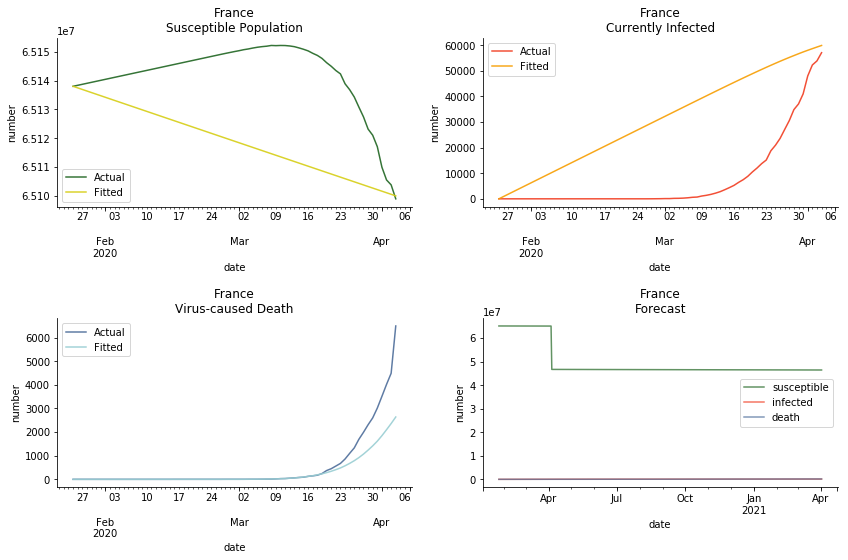

In [28]:
data=datafr.copy(deep=True)
beta_guess,delta_guess=0.000175,0.003
if create_forecast(esdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-fr--powerlaw.csv')


Infection Rate: 1.18783e-05
Fatality Rate: 0.00124

Basic Reproductive Ratio: 1.6817877308256413



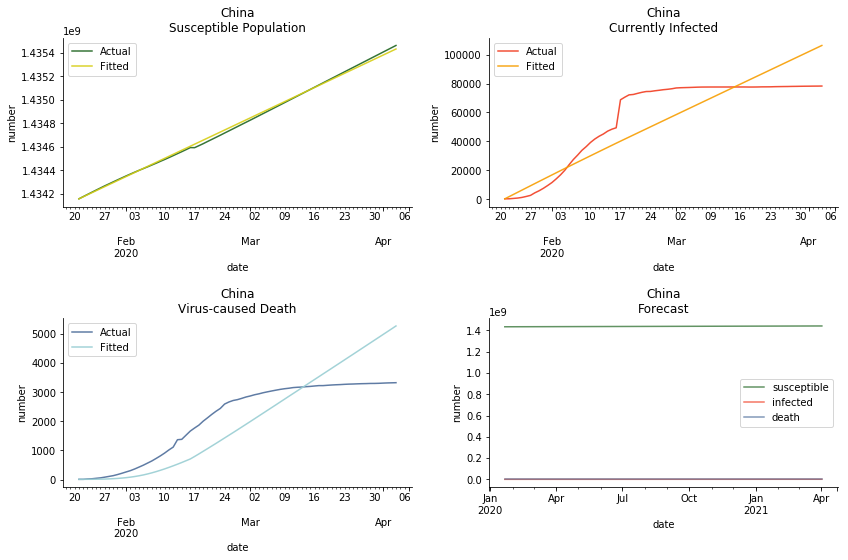

In [29]:
data=datacn.copy(deep=True)
beta_guess,delta_guess=0.0000104,0.00145
if create_forecast(cndemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-cn--powerlaw.csv')


Infection Rate: 7.1861e-05
Fatality Rate: 0.00713

Basic Reproductive Ratio: 1.770318367338202



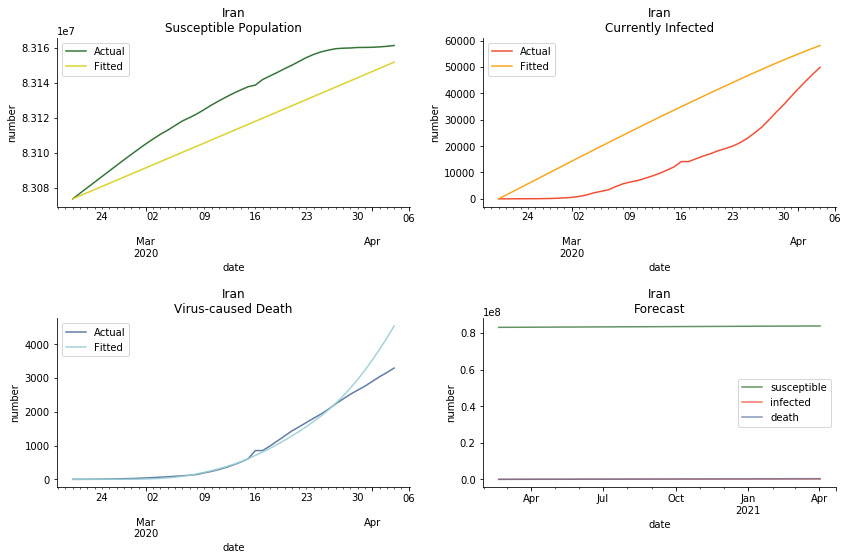

In [30]:
data=datair.copy(deep=True)
beta_guess,delta_guess=0.000078,0.0066
if create_forecast(irdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-ir--powerlaw.csv')


Infection Rate: 4.62077e-05
Fatality Rate: 0.0046

Basic Reproductive Ratio: 1.7634754886546833



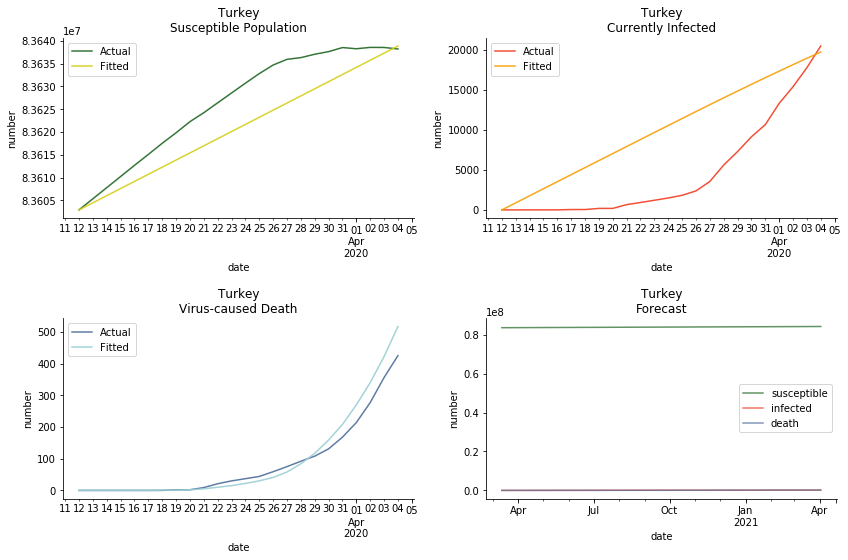

In [31]:
data=datatk.copy(deep=True)
beta_guess,delta_guess=0.002,0.005
if create_forecast(tkdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-tk--powerlaw.csv')


Infection Rate: 9.5445e-06
Fatality Rate: 0.00085

Basic Reproductive Ratio: 1.9788532920140443



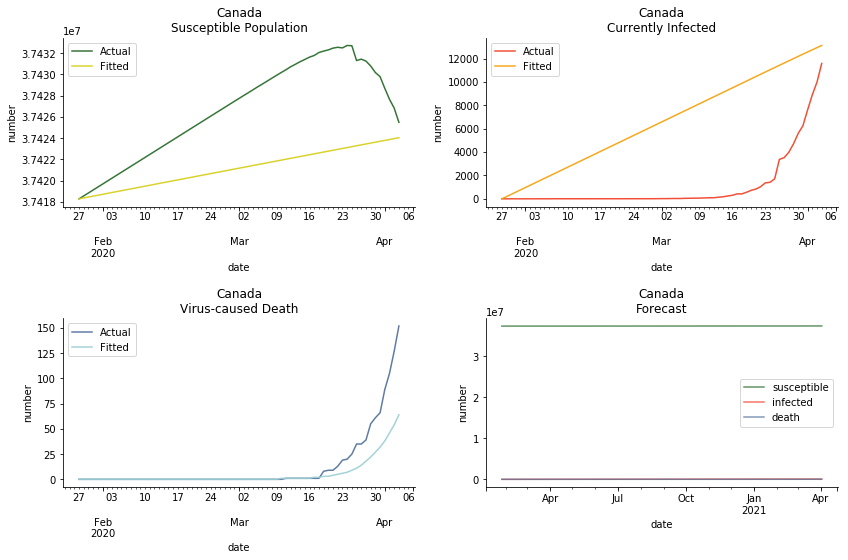

In [32]:
data=dataca.copy(deep=True)
beta_guess,delta_guess=0.0000095,0.0009
if create_forecast(cademographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-ca--powerlaw.csv')


Infection Rate: 7.8401e-06
Fatality Rate: 0.00073

Basic Reproductive Ratio: 1.8771316569365197



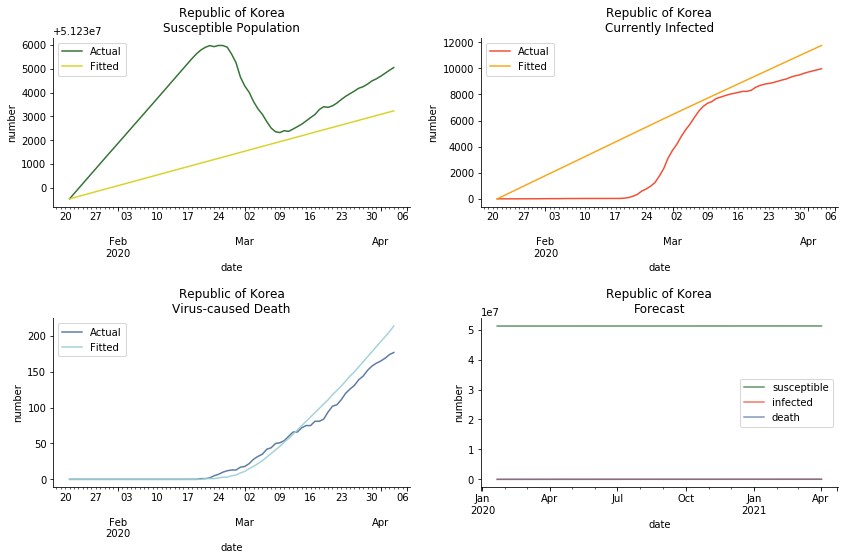

In [33]:
data=datakr.copy(deep=True)
beta_guess,delta_guess=0.0000043,0.008
if create_forecast(krdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-kr--powerlaw.csv')


Infection Rate: 1.24581e-05
Fatality Rate: 0.0013

Basic Reproductive Ratio: 1.6821537009435765



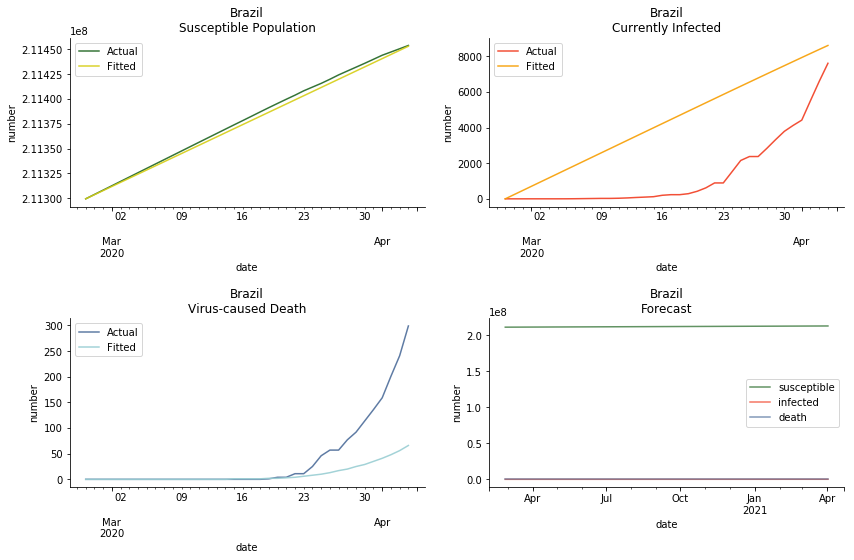

In [34]:
data=databr.copy(deep=True)
beta_guess,delta_guess=0.0000079,0.003
if create_forecast(brdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-br--powerlaw.csv')


Infection Rate: 9.71e-06
Fatality Rate: 0.0003

Basic Reproductive Ratio: 5.58465537456685



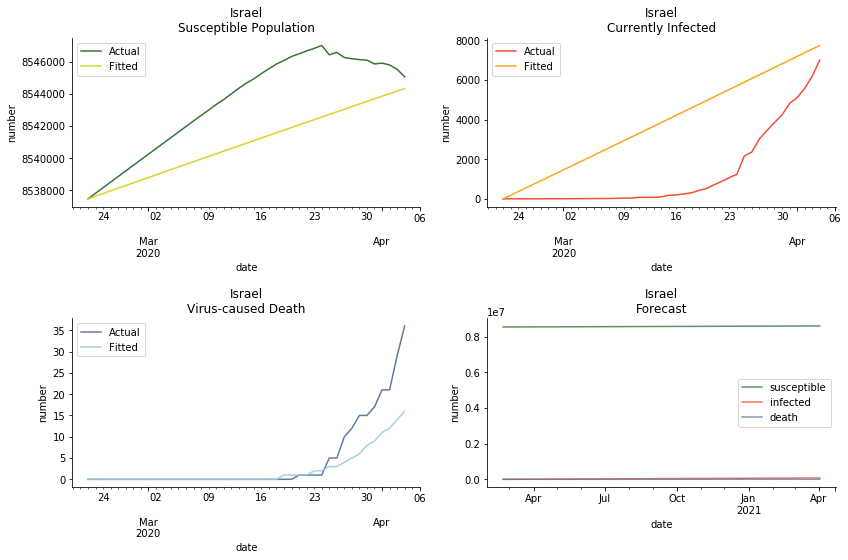

In [35]:
data=datais.copy(deep=True)
beta_guess,delta_guess=0.000009,0.0005
if create_forecast(isdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-is--powerlaw.csv')


Infection Rate: 8.2106e-06
Fatality Rate: 0.00077

Basic Reproductive Ratio: 1.8726909802164795



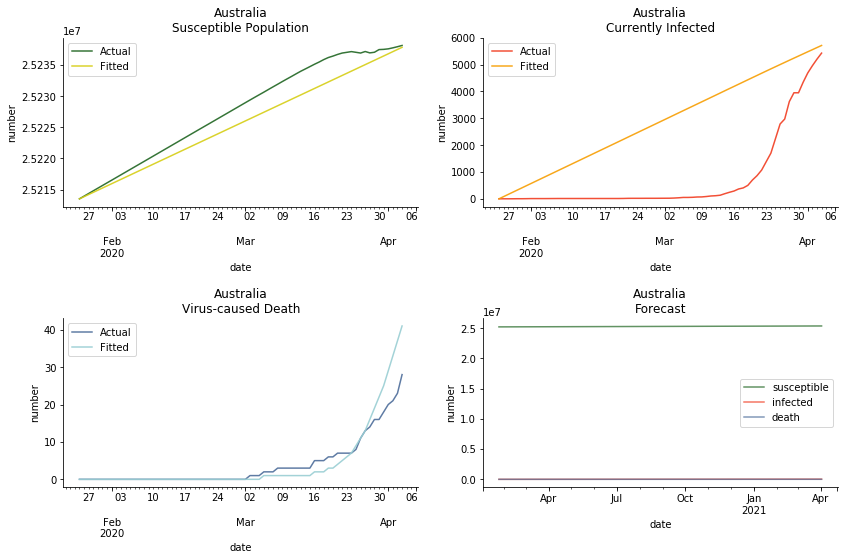

In [36]:
data=dataau.copy(deep=True)
beta_guess,delta_guess=0.0000087,0.0008
if create_forecast(audemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-au--powerlaw.csv')


Infection Rate: 6.9234e-06
Fatality Rate: 0.00049

Basic Reproductive Ratio: 2.4933568234941426



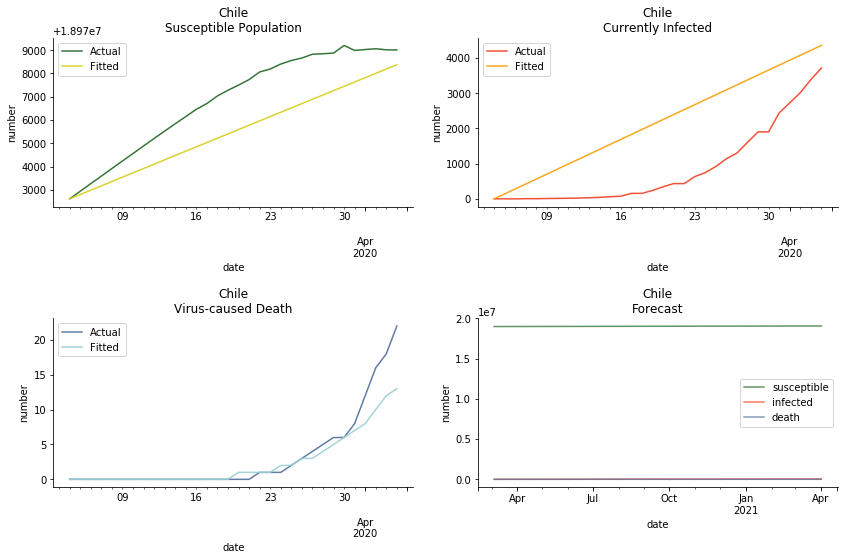

In [37]:
data=datacl.copy(deep=True)
beta_guess,delta_guess=0.000007,0.0005
if create_forecast(cldemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-cl--powerlaw.csv')


Infection Rate: 2.3408e-06
Fatality Rate: 0.00022

Basic Reproductive Ratio: 1.9022719157879224



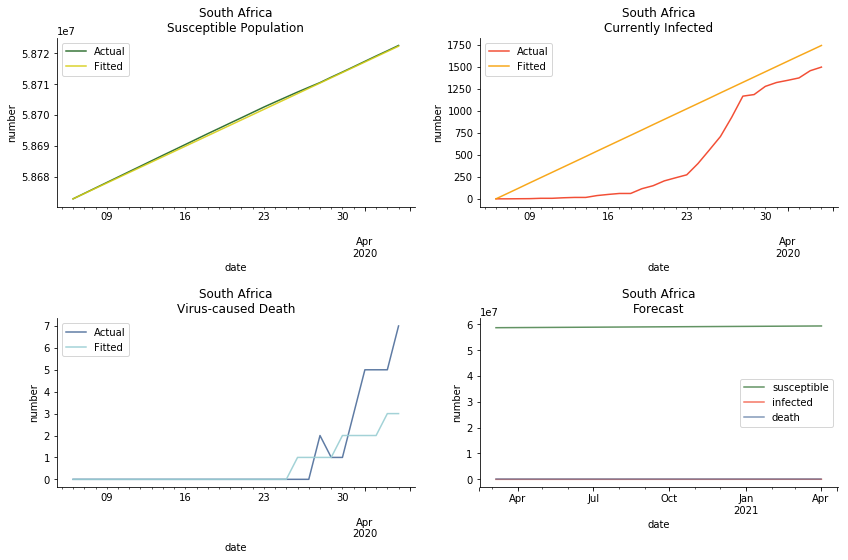

In [38]:
data=datasf.copy(deep=True)
beta_guess,delta_guess=0.0000025,0.0002
if create_forecast(sfdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-sf--powerlaw.csv')


Infection Rate: 9.22497e-05
Fatality Rate: 0.00991

Basic Reproductive Ratio: 1.6376353204515623



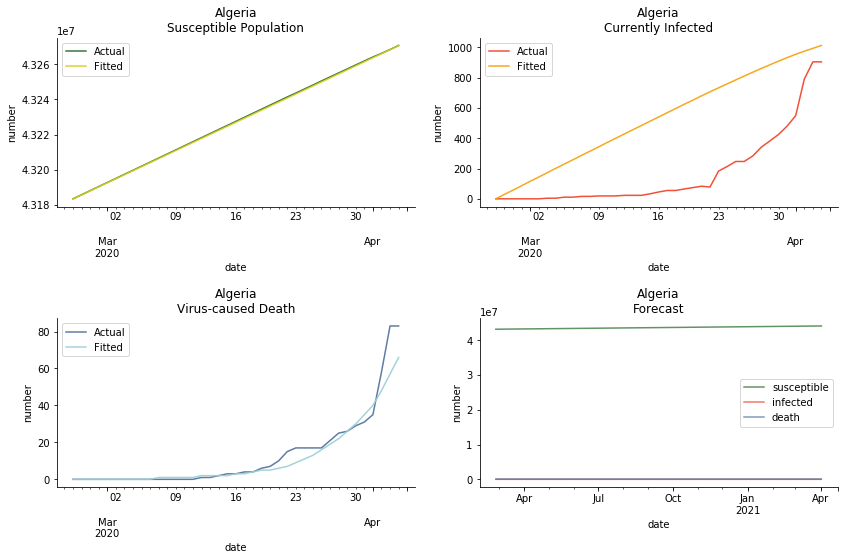

In [39]:
data=dataal.copy(deep=True)
beta_guess,delta_guess=0.00008959,0.01
if create_forecast(aldemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-al--powerlaw.csv')


Infection Rate: 3.6943e-06
Fatality Rate: 0.00022

Basic Reproductive Ratio: 2.925515569575



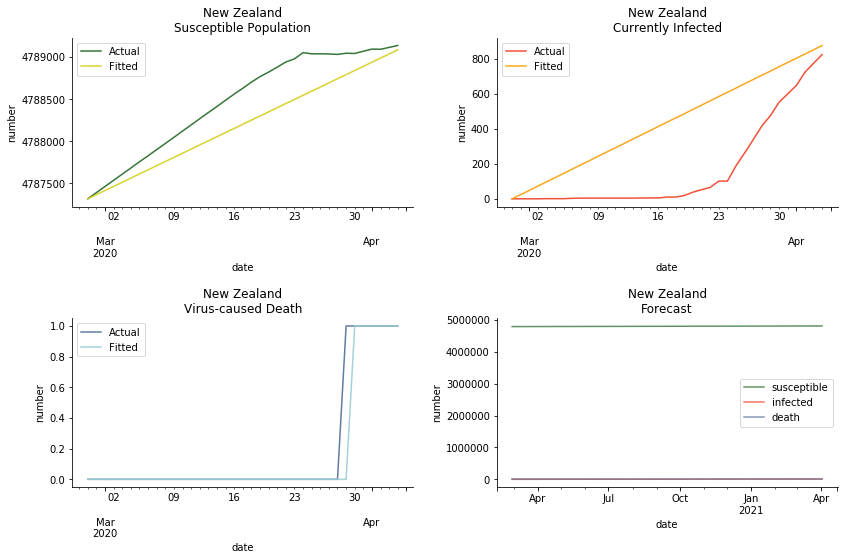

In [40]:
data=datanz.copy(deep=True)
beta_guess,delta_guess=0.000003,0.0003
if create_forecast(nzdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()
data.to_csv('corona-nz--powerlaw.csv')


Infection Rate: 2.49164e-05
Fatality Rate: 0.00228

Basic Reproductive Ratio: 1.916282531063288



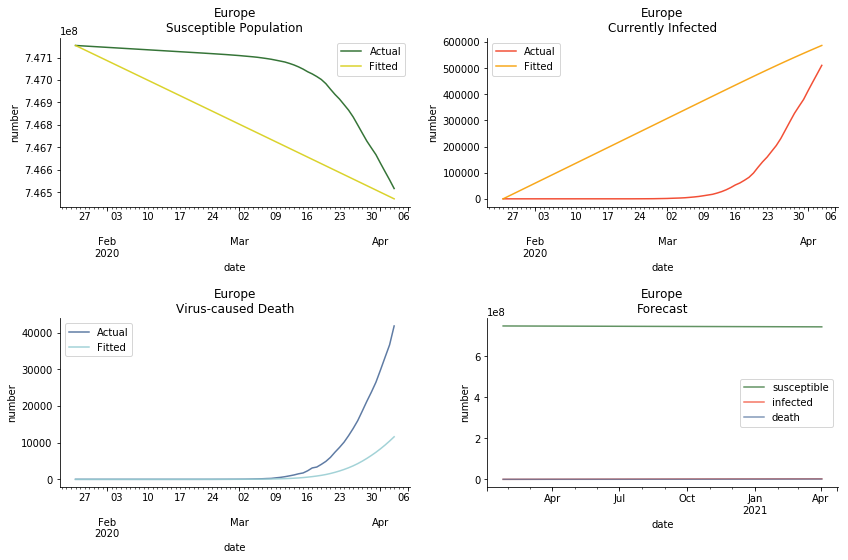

In [41]:
data=dataeu.copy(deep=True)
beta_guess,delta_guess=0.0000205,0.003
if create_forecast(eudemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()

data.to_csv('corona-eu--powerlaw.csv')


Infection Rate: 4.11266e-05
Fatality Rate: 0.00442

Basic Reproductive Ratio: 1.6356225282090475



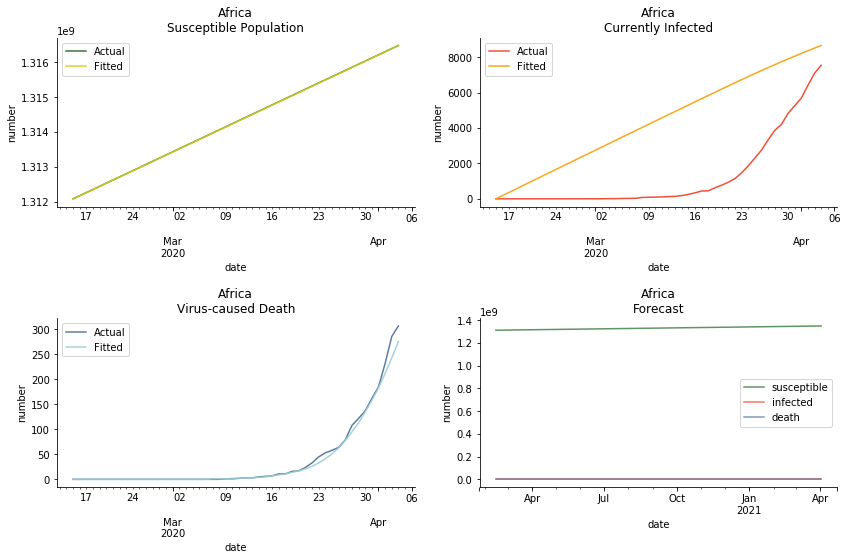

In [42]:
data=dataaf.copy(deep=True)
beta_guess,delta_guess=0.00003336,0.005
if create_forecast(afdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()

data.to_csv('corona-af--powerlaw.csv')


Infection Rate: 2.61567e-05
Fatality Rate: 0.00277

Basic Reproductive Ratio: 1.6601994925268888



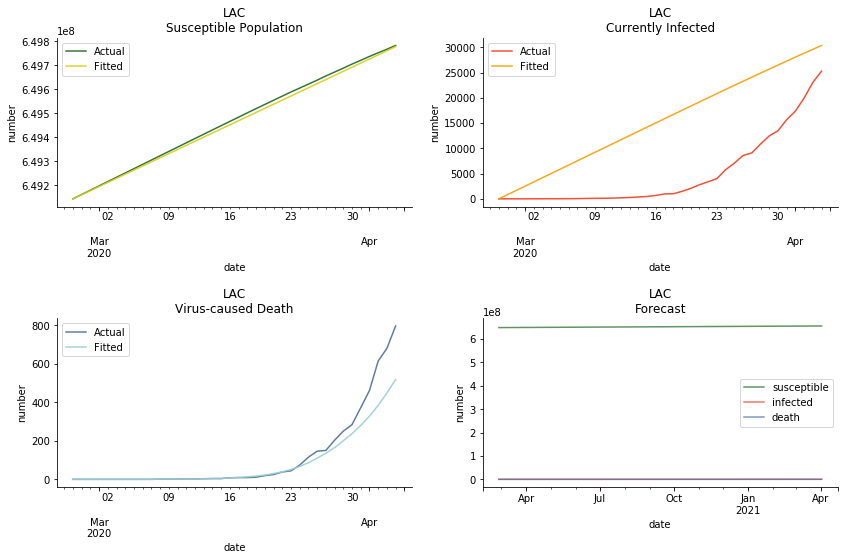

In [43]:
data=datalc.copy(deep=True)
beta_guess,delta_guess=0.0000246,0.003
if create_forecast(lcdemographic,
                   beta_guess=beta_guess,
                   delta_guess=delta_guess,
                   diagnosis=True):
    plot_all()


data.to_csv('corona-lc--powerlaw.csv')